# Tensorfow 모델에 pruning 적용하는 방법

1. 개요
    - pruning 알고리즘은 'graudal pruning' 방식 적용: 목표 sparisty값에 도달할때까지 진행하며 pruning 속도를 완만하게 늦춘다
    - 실험: CIFAR10 CNN 모델에 pruning 알고리즘 적용

2. 진행 방식

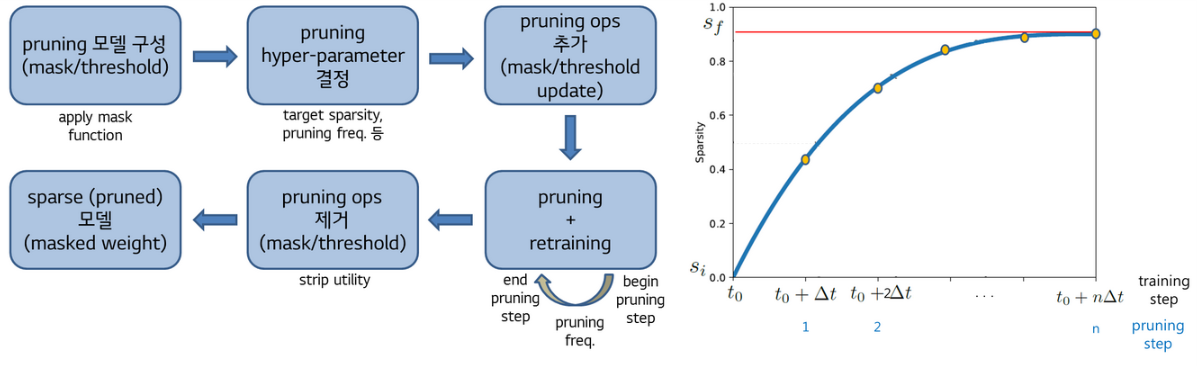

3. pruning 모델 생서
    - pruning 대상이 되는 layer에 mask와 threshold 변수를 추가한다
    - mask는 해당 layer의 weight tensor와 shape이 일하며 forward execution에 적용할 weight을 결정하는 역할을 수행함
    - apply_mask()함수를 이용하여 layer의 weight tensor를 wrapping 함으로써, mask와 threshold가 추가된 convolutional layer를 생성한다
    